In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import percentileofscore
from scipy.signal import medfilt
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
%matplotlib inline

In [27]:
def mean_cov(x):
    return x.mean(axis=0), np.cov(x, rowvar=False)

def mv_normal_kl(mu0, sigma0, mu1, sigma1):
    sigma1_inv = np.linalg.inv(sigma1)
    mean_diff = mu1 - mu0
    d = mu1.size
    tr = np.trace(sigma1_inv.dot(sigma0))
    means = mean_diff.dot(sigma1_inv).dot(mean_diff)
    logdets = np.log(np.linalg.det(sigma1)) - np.log(np.linalg.det(sigma0))
    return .5 * (tr + means + logdets - d)

def mv_normal_jeffreys(mu0, sigma0, mu1, sigma1):
    return .5 * (mv_normal_kl(mu0, sigma0, mu1, sigma1) +
                 mv_normal_kl(mu1, sigma1, mu0, sigma0))

def mv_normal_jeffreys_data(x0, x1):
    mu0, sigma0 = mean_cov(x0)
    mu1, sigma1 = mean_cov(x1)
    return mv_normal_jeffreys(mu0, sigma0, mu1, sigma1)

def linear_discriminability(mu0, mu1, sigma):
    mean_diff = mu1 - mu0
    return mean_diff.dot(np.linalg.inv(sigma)).dot(mean_diff)

def linear_discriminability_data(x0, x1):
    mu0 = x0.mean(axis=0)
    mu1 = x1.mean(axis=0)
    sigma = np.cov(np.concatenate((x0, x1)), rowvar=False)
    return linear_discriminability(mu0, mu1, sigma)

def qda_data(x0, x1):
    X = np.concatenate((x0, x1))
    Y = np.zeros(X.shape[0])
    Y[:x0.shape[0]] = 1
    model = QDA().fit(X, Y)
    return model.score(X, Y)

def plot_elipses(mu0, sigma0, mu1, sigma1, ld_sigma=None):
    assert mu0.size == 2
    f, ax = plt.subplots(1, figsize=(5, 5))
    c0, c1 = u'#1f77b4', u'#ff7f0e'
    for mu, sigma, c in [(mu0, sigma0, c0), (mu1, sigma1, c1)]:
        e, v = np.linalg.eigh(sigma)
        e = np.sqrt(e)
        ell = Ellipse(mu, e[1], e[0], 180. * np.arctan2(v[0, -1], v[1, -1]) / np.pi,
                      facecolor=c, alpha=.5)
        ax.plot(mu[0], mu[1], 'o', c=c)
        ax.add_artist(ell)
    if ld_sigma is not None:
        e, v = np.linalg.eigh(ld_sigma)
        e = np.sqrt(e)
        ell = Ellipse(.5*(mu0+mu1), e[1], e[0], 180. * np.arctan2(v[0, -1], v[1, -1]) / np.pi,
                      facecolor='None', alpha=.5, edgecolor='k')
        ax.add_artist(ell)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)

In [28]:
mu0 = np.array([1., .5])
mu1 = np.array([.5, 1.])
sigma0 = np.array([[1.5, 1.], [1., 1.5]])
sigma1 = np.array([[1.5, 1.], [1., 1.5]])
mv_normal_jeffreys(mu0, sigma0, mu1, sigma1)

0.5

# Sampling

In [33]:
draws = 10000
LD_samples = 100
kl = []
ld = []
qd = []
sigma0s = []
sigma1s = []
ld_sigmas = []

initial_kl = mv_normal_jeffreys(mu0, sigma1, mu1, sigma1)
x0 = np.random.multivariate_normal(mu0, sigma0, size=LD_samples)
x1 = np.random.multivariate_normal(mu1, sigma1, size=LD_samples)
initial_ld = linear_discriminability_data(x0, x1)
initial_ld_sigma = np.cov(np.concatenate((x0, x1)), rowvar=False)

a0 = np.pi / 2.
R0 = np.array([[np.cos(a0), np.sin(a0)], [-np.sin(a0), np.cos(a0)]])
sigma0_t = R0.dot(sigma0).dot(R0.T)
a1 = np.pi / 2.
R1 = np.array([[np.cos(a1), np.sin(a1)], [-np.sin(a1), np.cos(a1)]])
sigma1_t = R1.dot(sigma1).dot(R1.T)
t_kl = mv_normal_jeffreys(mu0, sigma0_t, mu1, sigma1_t)
x0 = np.random.multivariate_normal(mu0, sigma0_t, size=LD_samples)
x1 = np.random.multivariate_normal(mu1, sigma1_t, size=LD_samples)
t_ld = linear_discriminability_data(x0, x1)
sigma_ld_t = np.cov(np.concatenate((x0, x1)), rowvar=False)

for ii in range(draws):
    a0 = 2. * np.pi * np.random.rand()
    R0 = np.array([[np.cos(a0), np.sin(a0)], [-np.sin(a0), np.cos(a0)]])
    sigma0_p = R0.dot(sigma0).dot(R0.T)
    a1 = 2. * np.pi * np.random.rand()
    R1 = np.array([[np.cos(a1), np.sin(a1)], [-np.sin(a1), np.cos(a1)]])
    sigma1_p = R1.dot(sigma1).dot(R1.T)
    kl.append(mv_normal_jeffreys(mu0, sigma0_p, mu1, sigma1_p))
    x0 = np.random.multivariate_normal(mu0, sigma0_p, size=LD_samples)
    x1 = np.random.multivariate_normal(mu1, sigma1_p, size=LD_samples)
    ld.append(linear_discriminability_data(x0, x1))
    qd.append(qda_data(x0, x1))
    sigma0s.append(sigma0_p)
    sigma1s.append(sigma1_p)
    ld_sigmas.append(np.cov(np.concatenate((x0, x1)), rowvar=False))

kl = np.array(kl)
idxs = np.argsort(kl)
kl = kl[idxs]
ld = np.array(ld)[idxs]
qd = np.array(qd)[idxs]
sigma0s = np.array(sigma0s)[idxs]
sigma1s = np.array(sigma1s)[idxs]
ld_sigmas = np.array(ld_sigmas)[idxs]

#kl_percentile = np.zeros_like(kl)
#ld_percentile = np.zeros_like(ld)
#for ii in range(draws):
#    kl_percentile[ii] = percentileofscore(kl, kl[ii], 'weak')
#    ld_percentile[ii] = percentileofscore(ld, ld[ii], 'weak')

#idx_ld = np.argsort(ld)
#print(ld)
#print(ld_percentile)
#print(idx_ld)
#idx_kl = np.argsort(kl)

kl_percentile = kl.argsort().argsort() / kl.size
ld_percentile = ld.argsort().argsort() / ld.size
qd_percentile = qd.argsort().argsort() / qd.size

black dot, orthogonal major axis
KL: 0.5, 20.19th percentile over all configurations
LD: 0.6081710583474257, 80.64th percentile over all configurations

purple dot, parallel major axis
KL: 0.10000000000000009, 0.0th percentile over all configurations
LD: 0.42969813202024304, 56.53th percentile over all configurations

red dot, largest percentile difference
KL: 1.9042823329772371, 99.32th percentile over all configurations
LD: 0.07187061898576162, 1.2th percentile over all configurations

gray dot, largest linear discriminability
KL: 0.5494548073678397, 23.7th percentile over all configurations
LD: 1.3733654425609538, 100.0th percentile over all configurations

yellow dot, smallest linear discriminability
KL: 0.3275809890294352, 9.43th percentile over all configurations
LD: 0.000701515535528994, 0.01th percentile over all configurations

green dot, smallest kl
KL: 0.10022996612821966, 0.01th percentile over all configurations
LD: 0.10001525966704163, 2.66th percentile over all configura

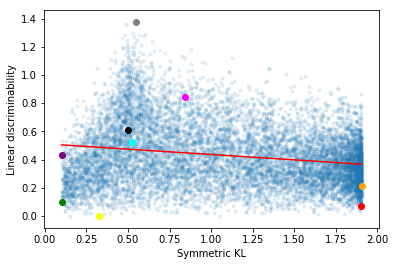

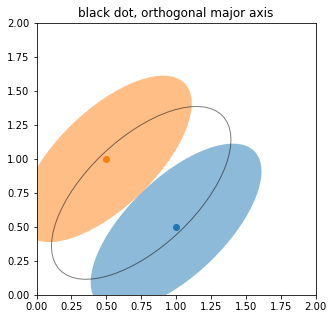

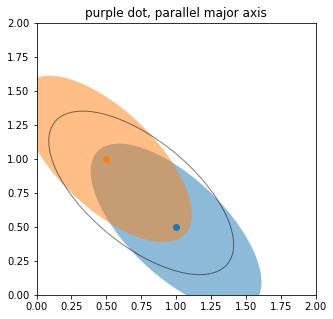

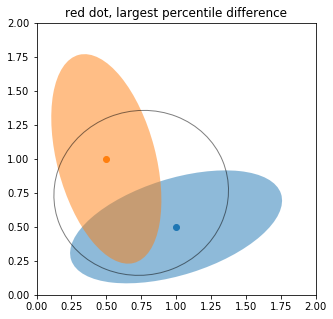

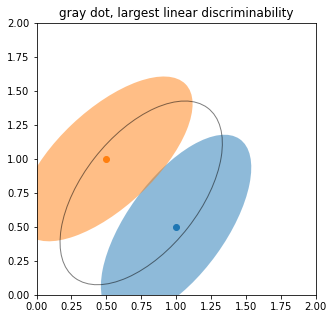

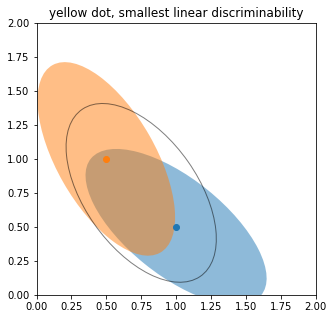

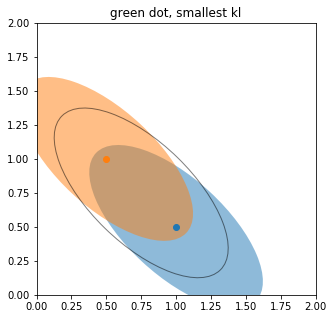

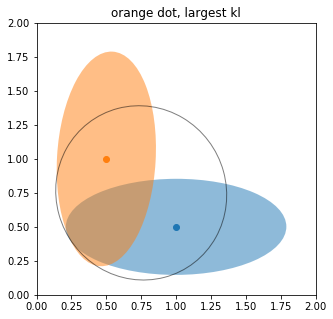

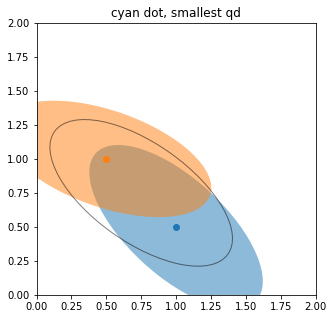

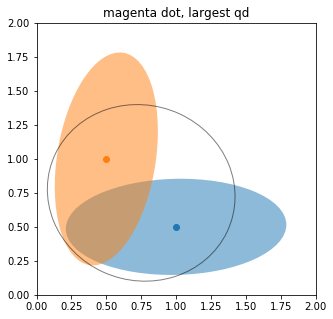

In [34]:
def plot(x, y, mu0, sigma0, mu1, sigma1, ld_sigma, ax, c, comment=None):
    ax.scatter(x, y, c=c)
    f = plt.figure()
    plot_elipses(mu0, sigma0, mu1, sigma1, ld_sigma)
    if comment is None:
        plt.title('{} dot'.format(c))
        print('{} dot'.format(c))
    else:
        plt.title('{} dot, {}'.format(c, comment))
        print('{} dot, {}'.format(c, comment))
    print("KL: {}, {}th percentile over all configurations".format(x, round(percentileofscore(kl, x), 2)))
    print("LD: {}, {}th percentile over all configurations\n".format(y, round(percentileofscore(ld, y), 2)))

f, ax = plt.subplots(1)
ax.scatter(kl, ld, marker='.', alpha=.1)
model = LinearRegression().fit(kl[:,np.newaxis], ld[:,np.newaxis])
xmin = kl.min()
xmax = kl.max()
m = np.squeeze(model.coef_)
b = np.squeeze(model.intercept_)
ax.plot([xmin, xmax], [m * xmin + b, m * xmax + b], 'red')
ax.set_xlabel('Symmetric KL')
ax.set_ylabel('Linear discriminability')

plot(initial_kl, initial_ld, mu0, sigma0, mu1, sigma1, initial_ld_sigma, ax, 'black',
     'orthogonal major axis')

plot(t_kl, t_ld, mu0, sigma0_t, mu1, sigma1_t, sigma_ld_t, ax, 'purple',
     'parallel major axis')

idx = abs(kl_percentile - ld_percentile).argmax()
plot(kl[idx], ld[idx], mu0, sigma0s[idx], mu1, sigma1s[idx], ld_sigmas[idx], ax, 'red',
     'largest percentile difference')

idx = ld_percentile.argmax()
plot(kl[idx], ld[idx], mu0, sigma0s[idx], mu1, sigma1s[idx], ld_sigmas[idx], ax, 'gray',
     'largest linear discriminability')

idx = ld_percentile.argmin()
plot(kl[idx], ld[idx], mu0, sigma0s[idx], mu1, sigma1s[idx], ld_sigmas[idx], ax, 'yellow',
     'smallest linear discriminability')

idx = kl_percentile.argmin()
plot(kl[idx], ld[idx], mu0, sigma0s[idx], mu1, sigma1s[idx], ld_sigmas[idx], ax, 'green',
     'smallest kl')

idx = kl_percentile.argmax()
plot(kl[idx], ld[idx], mu0, sigma0s[idx], mu1, sigma1s[idx], ld_sigmas[idx], ax, 'orange',
     'largest kl')

idx = qd_percentile.argmin()
plot(qd[idx], qd[idx], mu0, sigma0s[idx], mu1, sigma1s[idx], ld_sigmas[idx], ax, 'cyan',
     'smallest qd')

idx = qd_percentile.argmax()
plot(qd[idx], qd[idx], mu0, sigma0s[idx], mu1, sigma1s[idx], ld_sigmas[idx], ax, 'magenta',
     'largest qd')

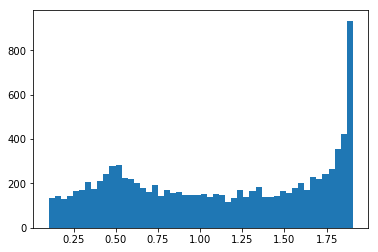

In [35]:
_ = plt.hist(kl, bins=50)

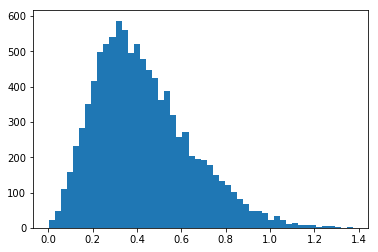

In [36]:
_ = plt.hist(ld, bins=50)

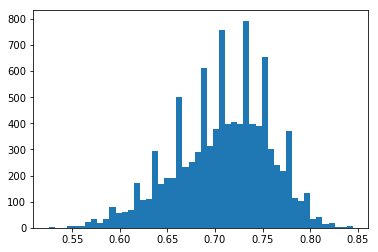

In [37]:
_ = plt.hist(qd, bins=50)

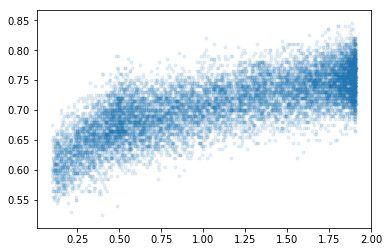

In [40]:
plt.scatter(kl, qd, marker='.', alpha=.1)

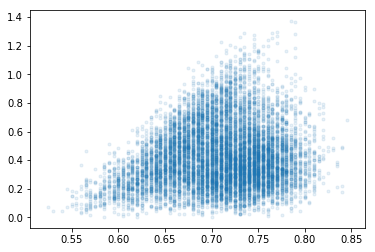

In [41]:
plt.scatter(qd, ld, marker='.', alpha=.1)

# Values

In [30]:
angles = 100
LD_samples = 1000

a0s = np.linspace(0, 2 * np.pi, angles, endpoint=False)
a1s = np.linspace(0, 2 * np.pi, angles, endpoint=False)

kl = np.zeros((angles, angles))
ld = np.zeros((angles, angles))
qd = np.zeros((angles, angles))


for ii, a0 in enumerate(a0s):
    for jj, a1 in enumerate(a1s):
        R0 = np.array([[np.cos(a0), np.sin(a0)], [-np.sin(a0), np.cos(a0)]])
        sigma0_p = R0.dot(sigma0).dot(R0.T)
        R1 = np.array([[np.cos(a1), np.sin(a1)], [-np.sin(a1), np.cos(a1)]])
        sigma1_p = R1.dot(sigma1).dot(R1.T)
        kl[ii, jj] = mv_normal_jeffreys(mu0, sigma0_p, mu1, sigma1_p)
        x0 = np.random.multivariate_normal(mu0, sigma0_p, size=LD_samples)
        x1 = np.random.multivariate_normal(mu1, sigma1_p, size=LD_samples)
        ld[ii, jj] = linear_discriminability_data(x0, x1)
        qd[ii, jj] = qda_data(x0, x1)

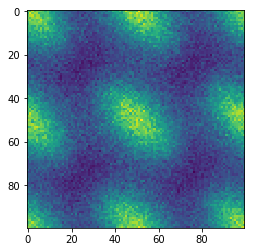

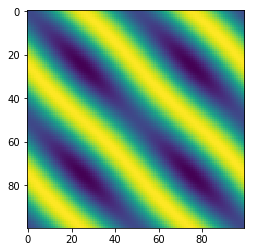

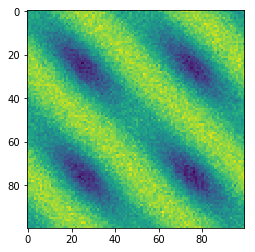

In [31]:
plt.figure()
plt.imshow(ld)
plt.figure()
plt.imshow(kl)
plt.figure()
plt.imshow(qd)